In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
from scipy.signal import correlate, find_peaks, hilbert, resample
from scipy import signal

from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stm
import neurolib.utils.functions as func  
from neurolib.utils.signal import Signal
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import neurolib.optimize.exploration.explorationUtils as eu
from neurolib.utils.loadData import Dataset

import os
import sys

sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

## Pic of Arnold's Tongue from sine input and PRC prediction

### PRC prediction is based on convolution of iPRC and sine

In [2]:
def lambda_factory(ab):
    return lambda x:x*ab[0]+ab[1]

def broken_line(x, x0, y0):
    cl = []
    fl = []
    for i in range(len(x0)-1):
        ab = np.polyfit(x0[i:i+2], y0[i:i+2], 1)
        #ic(ab)
        # Compute and append a "condition" interval
        cl.append(np.logical_and(x >= x0[i], x <= x0[i+1]))
        # Create a line function for the interval
        fl.append(lambda_factory(ab))
    return(np.piecewise(x, condlist=cl, funclist=fl))


def f1(x):
    return broken_line(x, x1, y1)

def f2(x):
    return broken_line(x, x2[::-1], y2[::-1])

def f(xy):
    x, y = xy
    z = np.array([y - f1(x), y - f2(x)])
    return z

In [3]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
#aln.params['Ke_gl'] = 30.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.28421052631579


initialised ...


In [6]:
prc_xcorr = np.load('data/PRC_1mV0,1ms.npy',allow_pickle='TRUE').item()

In [7]:
period_fr = prc.frperiod
phis = np.asarray(list(prc_xcorr.keys()))
prcs = np.asarray(list(prc_xcorr.values()))

# Have a data point for phi=0 and phi=T
phis = np.concatenate(([0.], phis))
phis = np.concatenate((phis, [period_fr]))
prcs = np.concatenate(([prcs[0]], prcs))
prcs = np.concatenate((prcs, [prcs[-1]]))
def prc_func(x):
    return broken_line(x, phis, prcs) 

In [8]:
def iPRC_func(phi):
    return prc_func(phi) / (2*10**(-14)*prc.frperiod) 

In [9]:
def sine_prc_bounds(sine_amplitude):
    # sine amplitude given in mV/ms
    xs = np.linspace(0, prc.frperiod, int(prc.frperiod*10))
    sig = iPRC_func(xs)
    # sine stimulus in Ampère
    sine = np.sin(np.linspace(-1.5*np.pi, 0.5*np.pi, len(xs))) * 2*10**(-14) * sine_amplitude
    sine2 = np.concatenate([sine, sine])
    sine_prc = signal.convolve(sig, sine2, mode='valid') 
    return [min(sine_prc), max(sine_prc)]

Text(0, 0.5, 'Stim Amp [pA]')

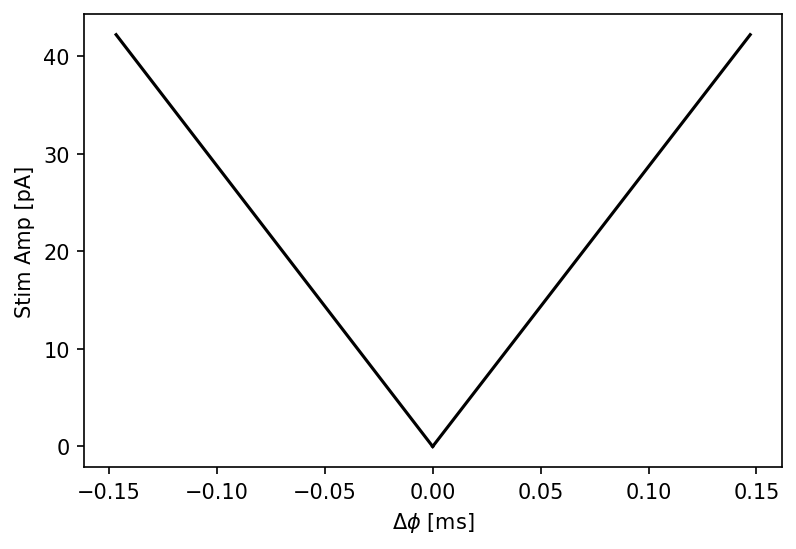

In [10]:
fig, ax = plt.subplots(dpi=150)
mins = []
maxs = []
amps = []
for stim_amp in np.arange(0, 0.212, 0.001):
    mi, ma = sine_prc_bounds(stim_amp)
    mins.append(mi)
    maxs.append(ma)
    amps.append(stim_amp*200)

ax.plot(mins, amps, c="black")
ax.plot(maxs, amps, c="black")
ax.set_xlabel(r"$\Delta \phi$ [ms]")
ax.set_ylabel(r"Stim Amp [pA]")

In [11]:
fr_period = prc.frperiod

Text(0, 0.5, 'Stim Amp [pA]')

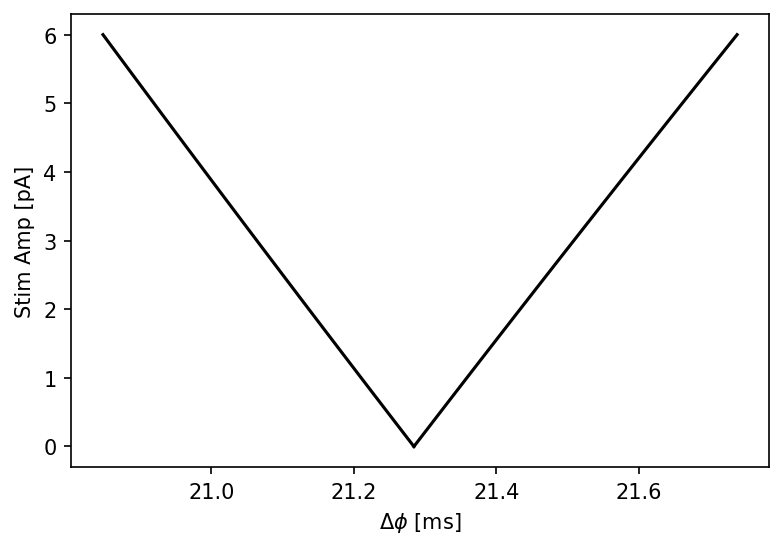

In [12]:
fig, ax = plt.subplots(dpi=150)
mins = []
maxs = []
amps = []
for stim_amp in np.arange(0, 0.0301, 0.001):
    mi, ma = sine_prc_bounds(stim_amp)
    mins.append(mi)
    maxs.append(ma)
    amps.append(stim_amp*200)

mins = np.asarray(mins)
maxs = np.asarray(maxs)
min_fr = 1000 / (fr_period + maxs*fr_period)
max_fr = 1000 / (fr_period + mins*fr_period)
ax.plot(min_fr, amps, c="black")
ax.plot(max_fr, amps, c="black")
ax.set_xlabel(r"$\Delta \phi$ [ms]")
ax.set_ylabel(r"Stim Amp [pA]")

## check kuramoto

In [13]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
aln.params['duration'] = 30000

INFO:root:aln: Model initialized.


In [14]:
stimulus = stm.SinusoidalInput(
        amplitude=0.02,
        frequency=21.,
        start=0,
        end=None,
        n=1
).as_array(aln.params.duration, aln.params.dt)

aln.randomICs()
aln.params['ext_exc_current'] = stimulus
aln.run()

In [15]:
stim = stimulus[0][::sampling]
#stim_phase = np.angle(hilbert(stim)) # otherwise kuramoto order parameter has problems

# ANALYSES    
#ic(len(aln.rates_exc[0].T))
dom_freq = dom_frequency(aln.rates_exc[0].T[500:], 
                         dt = aln.params.sampling_dt, 
                         SP_WINDOW=100)
stim_freq = dom_frequency(stim, 
                         dt = aln.params.sampling_dt, 
                         SP_WINDOW=100)
ic(dom_freq)
ic(stim_freq)

kuramoto = func.kuramoto(np.asarray([aln.rates_exc[0].T, stim][:]), prominence=0)


ic| dom_freq: 21.001669449081803
ic| stim_freq: 21.0


## simulation

In [17]:
def evalf(traj):
    pars = search.getParametersFromTraj(traj)
    stim_amp = pars['stim_amplitude']
    stim_freq = pars['stim_freq']

    stimulus = stm.SinusoidalInput(
            amplitude=stim_amp,
            frequency=stim_freq,
            start=0,
            end=None,
            n=1
    ).as_array(aln.params.duration, aln.params.dt)

    aln.randomICs()
    aln.params['ext_exc_current'] = stimulus
    aln.run()
    
    stim = stimulus[0][::sampling]
    stim_phase = np.angle(hilbert(stim)) # otherwise kuramoto order parameter has problems
    
    aln_phase = np.angle(hilbert(aln.rates_exc[0].T))
    # ANALYSES    
    start_eval = int(10000/aln.params['dt'])
    dom_freq = dom_frequency(aln.rates_exc[0].T[start_eval:], 
                             dt = aln.params.sampling_dt, 
                             SP_WINDOW=100)
    
    kuramoto = func.kuramoto(np.asarray([aln_phase[start_eval:], stim[start_eval:]]), prominence=0)
    
    # define whether entrained
    if np.std(kuramoto) < 0.2:
        entrainment = True
    else:
        entrainment = False
    # calc equilibrium phase at which stimulus is applied 
    if entrainment:
        last = int(-3 * frperiod / aln.params.sampling_dt)
        #print("last", last)
        model_l = aln.rates_exc[0][ last: ]

        # 1. get last two peaks of ALN
        peaks, props = find_peaks(model_l, prominence=3)

        # 2. find stimulus upstroke inside period given by two peaks
        stim_l = stim[ last + peaks[0] : last + peaks[1] ]
        upstrokes, _ = find_peaks(stim_l, prominence=0) 
        if len(upstrokes) > 0:
            #ic(upstrokes[0])
            stim_phase = upstrokes[0] * aln.params.sampling_dt  # pos. peak of sine stimulus in ms
        else:
            stim_phase = np.nan
    else:
        stim_phase = np.nan
        
    # reduce phase to frperiod interval
    if stim_phase > frperiod:
        stim_phase -= frperiod
    
    result_dict = {"dom_freq" : dom_freq,
                  "entrainment" : entrainment,
                  "stim_phase" : stim_phase,
                  "K_order_parameter" : np.std(kuramoto[1000 : 150000])}
    
    search.saveToPypet(result_dict, traj)
    return

In [18]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
aln.params['duration'] = 30000

INFO:root:aln: Model initialized.


In [19]:
fr_freq = 1000 / prc.frperiod
frperiod = 1000 / fr_freq

In [20]:
#stim_amplitude = np.hstack([0.001, np.arange(0.0005, 0.0301, 0.0005)])
stim_amplitude = np.arange(0.0005, 0.0301, 0.0005)

# stim freqs +-1 Hz of free running freq (= +- 2ms)
#stim_periods = np.arange(frperiod - 2, frperiod + 2, 0.05)
#fr_freq = 1000 / frperiod

stim_freq = np.arange(fr_freq - 0.7, fr_freq + 0.7, 0.02)
#stim_periods = np.asarray([frperiod])
#stim_freq = 1000 / stim_periods

parameters = ParameterSpace({"stim_amplitude": stim_amplitude,
                             "stim_freq" : stim_freq
                             })

search = BoxSearch(evalFunction = evalf,
                   parameterSpace = parameters,
                   filename = HDF_PATH+'Phase_Entrainment_Arnolds_sinestim_high_res4.hdf',
                   ncores=8)

INFO:root:Number of processes: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/Phase_Entrainment_Arnolds_sinestim_high_res4.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 4200
MainProcess root INFO     BoxSearch: Environment initialized.


In [101]:
#search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2021-12-13-09H-02M-25S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2021-12-13-09H-02M-25S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2021-12-13-09H-02M-25S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2021-12-13-09H-02M-25S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [21]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/Phase_Entrainment_Arnolds_sinestim_high_res4.hdf
MainProcess root INFO     Analyzing trajectory results-2021-12-13-09H-02M-25S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/Phase_Entrainment_Arnolds_sinestim_high_res4.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-12-13-09H-02M-25S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 4200/4200 [00:37<00:00, 113.41it/s]
MainProcess root INFO     All results lo

In [22]:
for i in search.dfResults.index:
    search.dfResults.loc[i, 'stim_amp_nA'] = search.dfResults['stim_amplitude'][i]*0.2
    search.dfResults.loc[i, 'stim_amp_pA'] = search.dfResults['stim_amplitude'][i]*200
    
    #search.dfResults.loc[i, 'K_std'] = np.std(search.dfResults['K_order_parameter'][i])
    #search.dfResults.loc[i, 'K_std_l'] = np.std(search.dfResults['K_order_parameter'][i][10000: 170000])
    
    #if np.isnan(search.dfResults['stim_phase'][i]):
    #    search.dfResults['stim_phase'][i] = -1

In [23]:
df = search.dfResults

In [24]:
fr_period = 1000 / fr_freq

Text(0, 0.5, 'Stimulation Amplitude [pA]')

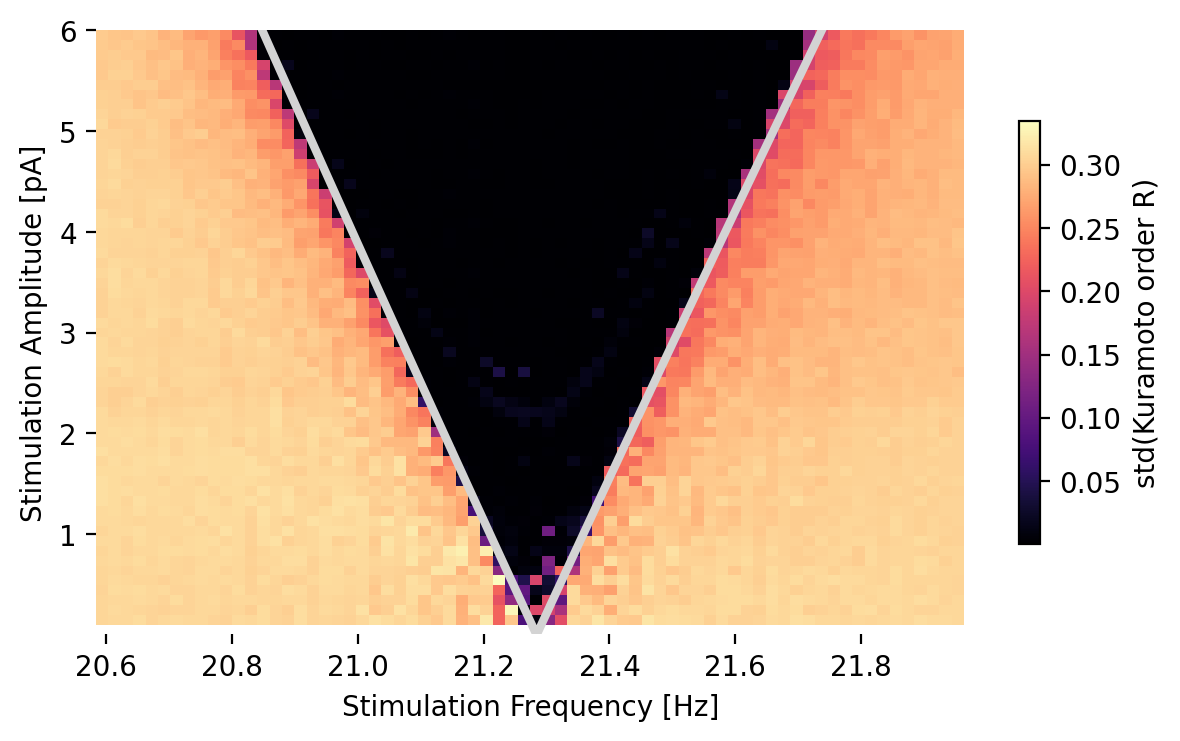

In [25]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)
table = df.pivot_table(values='K_order_parameter', index = 'stim_amp_pA', columns='stim_freq')
img = ax.imshow(table, \
   extent = [min(df.stim_freq), max(df.stim_freq),
             min(df.stim_amp_pA), max(df.stim_amp_pA)], 
    origin='lower',
    cmap="magma",
    )
cbar = fig.colorbar(img, anchor=(0, 0.3), shrink=0.7)
cbar.set_label('std(Kuramoto order R)')
                #vmin=min(df.domfreq),
                #vmax=max(df.domfreq))
#ax.set(frame_on=False)
max_f = 1000 / (prc.frperiod + mins*fr_period)
min_f = 1000 / (fr_period + maxs*fr_period)
ax.plot(min_f, amps, c="lightgrey", lw=3)
ax.plot(max_f, amps, c="lightgrey", lw=3)

ax.set_aspect("auto")
ax.set_ylim(0.005, 6)
#ax.set_xlim(20.6, 22)
#ln = ax.plot(df_prc.freqmin, df_prc.stim_amplitude*200, color=colrs[5], lw=4, label="minimal / maximal phase response compensation")
#ax.plot(df_prc.freqmax, df_prc.stim_amplitude*200, color=colrs[5], lw=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("Stimulation Frequency [Hz]")
ax.set_ylabel("Stimulation Amplitude [pA]")
#labs = [l.get_label() for l in ln]
#ax.legend(ln, labs, bbox_to_anchor=(0, 1.15), loc='upper left')
#ax.set_title("Sinusoidal Stimulation Entrainment: Prediction and Experiment", y=1.15)

## now with my style

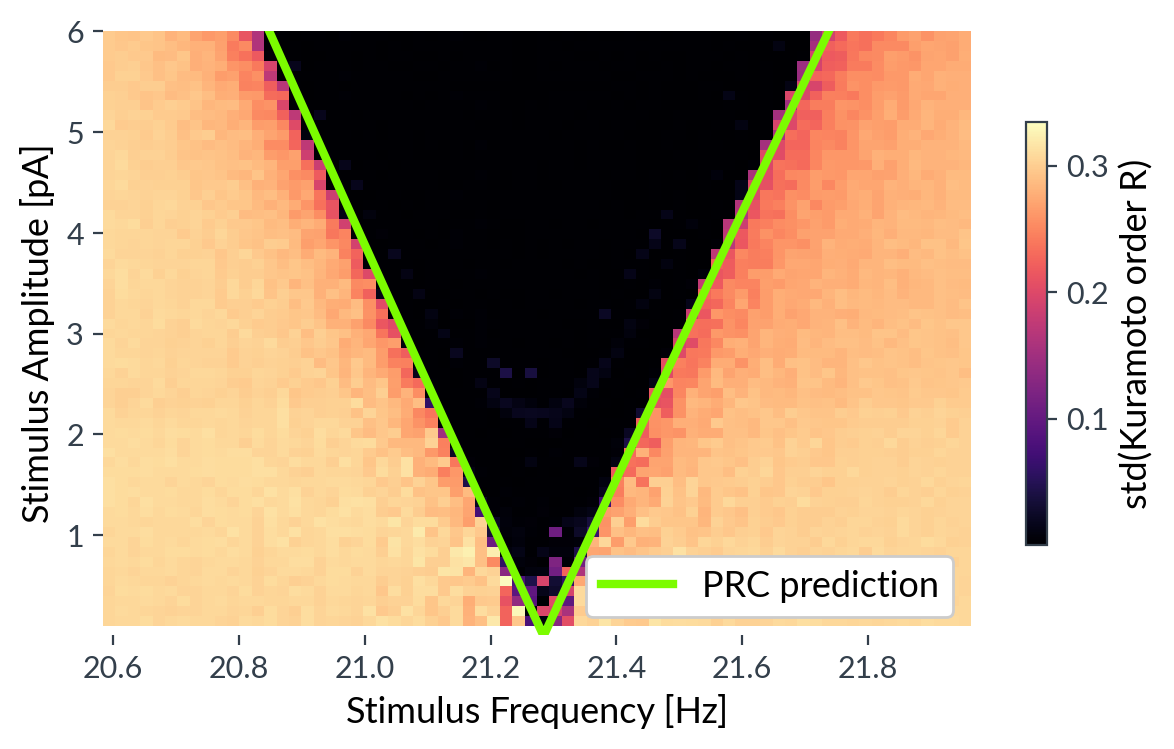

In [26]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, ax = plt.subplots(figsize=(7,4),dpi=200)
table = df.pivot_table(values='K_order_parameter', index = 'stim_amp_pA', columns='stim_freq')
img = ax.imshow(table, \
   extent = [min(df.stim_freq), max(df.stim_freq),
             min(df.stim_amp_pA), max(df.stim_amp_pA)], 
    origin='lower',
    cmap="magma",
    )
cbar = fig.colorbar(img, anchor=(0, 0.3), shrink=0.7)
cbar.set_label('std(Kuramoto order R)')
                #vmin=min(df.domfreq),
                #vmax=max(df.domfreq))
#ax.set(frame_on=False)
max_f = 1000 / (prc.frperiod + mins*fr_period)
min_f = 1000 / (fr_period + maxs*fr_period)
ax.plot(min_f, amps, c="lawngreen", lw=3, label="PRC prediction")
ax.plot(max_f, amps, c="lawngreen", lw=3)

ax.set_aspect("auto")
ax.set_ylim(0.005, 6)
#ax.set_xlim(20.6, 22)
#ln = ax.plot(df_prc.freqmin, df_prc.stim_amplitude*200, color=colrs[5], lw=4, label="minimal / maximal phase response compensation")
#ax.plot(df_prc.freqmax, df_prc.stim_amplitude*200, color=colrs[5], lw=4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("Stimulus Frequency [Hz]")
ax.set_ylabel("Stimulus Amplitude [pA]")

ax.legend(loc="lower right", framealpha=1.)

#fig.savefig("Pics/Arnolds_prediction.pdf")